<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/Generating_demands.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Сначала читаем данные для графа - тут из csv файлов для нашего проекта

In [1]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь
specified_graphs = ['cola_t3']
Graphs = get_graphs(path_to_folder, specified_graphs)

/tmp/ipython-input-1742972618.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])
/tmp/ipython-input-1742972618.py:34: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])


In [2]:
main_graph_for_test = Graphs['cola_t3']

Тут уже основной класс GraphMCF для генерации трафика по структуре смежности - на вход подается матрица смежности для неориентированного взвешенного графа. Как договаривались - вес ребра его capacity, мультиребра схлопываем по параллельному соединению, то есть сумма capacity

In [3]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Union, List

class GraphMCF:
    """
    Класс для работы с неориентированным взвешенным графом
    на основе матрицы смежности.

    Attributes:
        adjacency_matrix (np.ndarray): Матрица смежности графа
        graph (nx.Graph): Граф в формате NetworkX
        n (int): Количество вершин в графе
    """

    def __init__(self, adjacency_matrix: Union[np.ndarray, List[List[float]]]):
        """
        Инициализация графа из матрицы смежности.

        Args:
            adjacency_matrix: Матрица смежности неориентированного взвешенного графа.
                            Должна быть квадратной и симметричной.

        Raises:
            ValueError: Если матрица не квадратная или не симметричная
        """
        # Преобразуем в numpy array если нужно
        self.adjacency_matrix = np.array(adjacency_matrix, dtype=float)

        # Проверяем корректность матрицы
        self._validate_adjacency_matrix()

        # Создаем граф NetworkX
        self.graph = self._create_networkx_graph()
        self.n = len(self.adjacency_matrix)

        # Задаем важные атрибуты
        self.initial_demands_graph = None # Граф начальных корреспонденций
        self.demands_graph = None # Граф текущих корреспонденций

        self.alpha = None # Основной параметр для оценки проходимости
        self.L_alpha = None # Матрица основного параметра

        self.graph_spec = None # Спектр Лапласиана графа .graph

    def _validate_adjacency_matrix(self) -> None:
        """Проверяет корректность матрицы смежности."""
        if len(self.adjacency_matrix.shape) != 2:
            raise ValueError("Матрица смежности должна быть двумерной")

        if self.adjacency_matrix.shape[0] != self.adjacency_matrix.shape[1]:
            raise ValueError("Матрица смежности должна быть квадратной")

        # Проверяем симметричность (с учетом погрешности вычислений)
        if not np.allclose(self.adjacency_matrix, self.adjacency_matrix.T):
            raise ValueError("Матрица смежности должна быть симметричной для неориентированного графа")

        # Проверяем неотрицательность весов
        if np.any(self.adjacency_matrix < 0):
            raise ValueError("Веса ребер должны быть неотрицательными")

    def _create_networkx_graph(self) -> nx.Graph:
        """Создает граф NetworkX из матрицы смежности."""
        G = nx.Graph()
        n = len(self.adjacency_matrix)

        # Добавляем вершины
        G.add_nodes_from(range(n))

        # Добавляем ребра с весами
        for i in range(n):
            for j in range(i + 1, n):  # Только верхний треугольник для неориентированного графа
                weight = self.adjacency_matrix[i, j]
                if weight != 0:  # Добавляем только существующие ребра
                    G.add_edge(i, j, weight=weight)

        return G

    def visualize(self, title: str = "GraphMCF Visualization",
                  node_size: int = 300, font_size: int = 10) -> None:
        """
        Визуализирует граф с помощью matplotlib.

        Args:
            title: Заголовок графика
            node_size: Размер вершин
            font_size: Размер шрифта для подписей весов
        """
        plt.figure(figsize=(10, 8))

        # Позиционирование вершин
        pos = nx.spring_layout(self.graph)

        # Рисуем граф - без подписей вершин, темные вершины
        nx.draw_networkx_nodes(self.graph, pos, node_size=node_size,
                              node_color='steelblue', alpha=0.8)
        nx.draw_networkx_edges(self.graph, pos, alpha=0.7, edge_color='gray')

        # Подписываем только веса ребер (без подписей вершин)
        edge_labels = {(u, v): f"{d['weight']:.0f}"
                      for u, v, d in self.graph.edges(data=True)}
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels,
                                   font_size=font_size)

        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def generate_initial_demands(self, p=0.5, distribution='lognormal',
                                 min_weight=1, max_weight=100, **dist_params):
        """
        Генерирует начальный НЕориентированный граф корреспонденций на вершинах графа `self`
        с использованием модели Эрдӧша–Реньи и случайных весов.

        Args:
            p: Вероятность появления каждого возможного ребра корреспонденций
            distribution: Тип распределения для весов ('normal'/'lognormal'/'uniform'/'triangular')
            min_weight: Левая граница (минимальный вес, включительно)
            max_weight: Правая граница (cut-off, значения >= нему отбрасываются)
            **dist_params: Дополнительные параметры распределения
        """
        import numpy as np
        import networkx as nx
        import random

        # число вершин исходного графа
        n = self.n
        if n <= 0:
            raise ValueError("Исходный граф пуст.")

        # 1) Эрдёш–Реньи: неориентированный, невзвешенный
        G_rand = nx.erdos_renyi_graph(n, p, seed=None, directed=False)

        # 1a) Случайная перестановка и сопоставление с вершинами исходного графа
        base_nodes = list(self.graph.nodes())  # фактические метки вершин исходного графа
        perm = list(range(n))
        random.shuffle(perm)
        # сопоставляем индексы 0..n-1 к меткам исходного графа согласно перестановке
        mapping = {old_idx: base_nodes[perm[old_idx]] for old_idx in G_rand.nodes()}
        G_rand = nx.relabel_nodes(G_rand, mapping)

        # 2) Функция генерации веса с отсечением [min_weight, max_weight)
        def draw_weight():
            while True:
                if distribution == 'normal':
                    mu = dist_params.get('mu', 30)
                    sigma = dist_params.get('sigma', 5)
                    w = random.gauss(mu, sigma)
                elif distribution == 'lognormal':
                    mean_log = dist_params.get('mean_log', 3.5)
                    sigma_log = dist_params.get('sigma_log', 0.5)
                    w = float(np.random.lognormal(mean_log, sigma_log))
                elif distribution == 'uniform':
                    w = random.uniform(min_weight, max_weight)
                elif distribution == 'triangular':
                    mode = dist_params.get('mode', min_weight)
                    w = random.triangular(min_weight, max_weight, mode)
                else:
                    # по умолчанию логнормальное
                    w = float(np.random.lognormal(dist_params.get('mean_log', 3.5),
                                                  dist_params.get('sigma_log', 0.5)))
                # применяем границы
                if w < min_weight:
                    w = min_weight
                if w < max_weight:
                    return w
                # иначе перегенерируем

        # 3) Создаём НЕориентированный взвешенный граф корреспонденций
        Gd = nx.Graph()
        Gd.add_nodes_from(base_nodes)
        for u, v in G_rand.edges():
            Gd.add_edge(u, v, weight=round(draw_weight()))

        # 4) Сохраняем результат в атрибуты объекта
        self.initial_demands_graph = Gd
        self.demands_graph = Gd

    def visualise_with_demands(
        self,
        node_size: int = 110,
        font_size: int = 9,
        figsize=(14, 6),
        seed: int = 42,
        demand_edge_width_range=(1.5, 6.0),
        node_color: str = "dimgray",
        base_edge_color: str = "gray",
        demand_edge_cmap: str = "viridis",
        edge_alpha: float = 0.9,
        colorbar_label: str = "Вес корреспонденции",
    ):
        """
        Слева — исходный граф (с подписями весов), справа — НЕориентированный граф корреспонденций:
        без подписей рёбер, но с толщиной ~ весу и раскраской по колормэпу + легенда.

        Требует атрибут:
          - self.demands_graph (nx.Graph, НЕориентированный)
        """
        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import networkx as nx

        # --- проверка и выбор графа корреспонденций (НЕориентированный) ---
        if not hasattr(self, "demands_graph") or not isinstance(self.demands_graph, nx.Graph):
            raise AttributeError("Ожидается self.demands_graph типа nx.Graph (неориентированный).")
        DG = self.demands_graph

        # общая раскладка по spring для одинаковых позиций
        pos = nx.spring_layout(self.graph, seed=seed)

        fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=figsize)

        # ----- ЛЕВО: исходный граф (с подписями весов) -----
        nx.draw_networkx_nodes(
            self.graph, pos,
            node_size=node_size, node_color=node_color, alpha=0.95, ax=ax_left
        )
        nx.draw_networkx_edges(
            self.graph, pos,
            edge_color=base_edge_color, width=1.5, alpha=edge_alpha, ax=ax_left
        )
        edge_labels_left = {(u, v): f"{d.get('weight', 0):.0f}" for u, v, d in self.graph.edges(data=True)}
        if edge_labels_left:
            nx.draw_networkx_edge_labels(
                self.graph, pos, edge_labels=edge_labels_left,
                font_size=font_size, font_color="black", rotate=False, ax=ax_left
            )
        ax_left.set_title("Исходный граф", fontsize=12)
        ax_left.axis("off")

        # ----- ПРАВО: граф корреспонденций (толщина + цвет, БЕЗ подписей) -----
        nx.draw_networkx_nodes(
            DG, pos,
            node_size=node_size, node_color=node_color, alpha=0.95, ax=ax_right
        )

        edgelist = list(DG.edges(data=True))
        uv_list = [(u, v) for u, v, _ in edgelist]
        weights = [float(d.get("weight", 1.0)) for _, _, d in edgelist]

        # толщины рёбер ~ весам
        if weights:
            w_min, w_max = float(np.min(weights)), float(np.max(weights))
            w_lo, w_hi = demand_edge_width_range
            if np.isclose(w_min, w_max):
                widths = [0.5 * (w_lo + w_hi)] * len(weights)
            else:
                widths = [w_lo + (w - w_min) * (w_hi - w_lo) / (w_max - w_min) for w in weights]
        else:
            widths = []

        # цвет по колормэпу
        cmap = mpl.cm.get_cmap(demand_edge_cmap)
        if weights:
            vmin, vmax = float(np.min(weights)), float(np.max(weights))
        else:
            vmin, vmax = 0.0, 1.0  # чтобы colorbar не упал при пустом графе

        # рисуем НЕориентированные рёбра с раскраской по весу (без стрелок)
        ec = weights if weights else None
        nx.draw_networkx_edges(
            DG, pos,
            edgelist=uv_list,
            edge_color=ec,
            edge_cmap=cmap,
            edge_vmin=vmin,
            edge_vmax=vmax,
            width=widths if widths else 1.5,
            alpha=edge_alpha,
            ax=ax_right
        )

        # цветовая легенда (colorbar)
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax_right, fraction=0.046, pad=0.04)
        cbar.set_label(colorbar_label, fontsize=10)

        ax_right.set_title("Граф корреспонденций (неориент.)", fontsize=12)
        ax_right.axis("off")

        plt.tight_layout()
        plt.show()

    def calculate_alpha(self):
        """
        Вычисляет матрицу и параметр:
            L_alpha = (L_g^+)^{1/2} * L_d * (L_g^+)^{1/2},
        где L_g — взвешенный лапласиан исходного неориентированного графа self.graph,
            L_d — взвешенный лапласиан НЕориентированного графа корреспонденций self.demands_graph,
            (L_g^+)^{1/2} — квадратный корень из псевдообратной Мура–Пенроуза к L_g.

        Сохраняет:
            self.L_alpha : np.ndarray
            self.alpha   : float
        """
        import numpy as np
        import networkx as nx
        from scipy.linalg import fractional_matrix_power
        from scipy.sparse.linalg import eigsh

        if not hasattr(self, "demands_graph") or not isinstance(self.demands_graph, nx.Graph):
            raise AttributeError("Ожидается self.demands_graph типа nx.Graph (неориентированный).")

        nodelist = list(self.graph.nodes())
        if set(nodelist) != set(self.demands_graph.nodes()):
            raise ValueError("Множества вершин self.graph и self.demands_graph не совпадают.")

        # 1) лапласиан графа корреспонденций L_d
        Ld = nx.laplacian_matrix(self.demands_graph, nodelist=nodelist, weight="weight").astype(float).toarray()

        # 2) кэш: квадратный корень псевдообратной L_g
        if not hasattr(self, "graph_pinv_sqrt") or self.graph_pinv_sqrt is None:
            Lg = nx.laplacian_matrix(self.graph, nodelist=nodelist, weight="weight").astype(float).toarray()
            Lg_pinv = np.linalg.pinv(Lg)
            self.graph_pinv_sqrt = fractional_matrix_power(Lg_pinv, 0.5)
        Lg_inv_sqrt = self.graph_pinv_sqrt

        # 3) L_alpha
        L_alpha = Lg_inv_sqrt @ Ld @ Lg_inv_sqrt

        # 4) спектр и alpha
        lambda_max, _ = eigsh(L_alpha, k=1, which='LA')
        lambda_max = float(lambda_max[0])
        #eigvals = np.linalg.eigvalsh(L_alpha)
        #lambda_max = float(eigvals[-1]) if eigvals.size else 0.0
        trace_val = float(np.trace(L_alpha))
        alpha = (lambda_max / trace_val) if trace_val != 0.0 else np.inf

        # сохранить результаты
        self.L_alpha = L_alpha
        self.alpha = alpha
        return alpha

    def generate_cut(self, type: str = "friendly", rng_seed: int | None = None):
        """
        Генерирует вектор-направление разреза по спектру взвешенного лапласиана self.graph.

        type:
          - "friendly"    -> используем верхнюю половину (наибольшие собственные значения)
          - "adversarial" -> используем нижнюю половину (наименьшие ненулевые собственные значения)

        Алгоритм:
          1) Один раз считаем и кэшируем весь спектр L (кроме первого нулевого) в self.graph_spec.
          2) В зависимости от чётности числа собственных значений m=n-1:
             - если m чётно: нижняя половина = первые m/2, верхняя = последние m/2
             - если m нечётно: исключаем центральный элемент (медиану) и делим оставшиеся пополам
          3) Берём соответствующие собственные векторы (ортонормированы),
             генерируем неотрицательные коэффициенты (|N(0,1)|), формируем v и нормируем ||v||=1.
        Возвращает:
          np.ndarray формы (n,)
        """
        import numpy as np
        import networkx as nx

        if type not in ("friendly", "adversarial"):
            raise ValueError("type должен быть 'friendly' или 'adversarial'.")

        # 0) случайный генератор
        rng = np.random.default_rng(rng_seed)

        # 1) кэш спектра (взвешенный лапласиан)
        if not hasattr(self, "graph_spec") or self.graph_spec is None:
            # фиксируем порядок вершин
            nodelist = list(self.graph.nodes())
            # взвешенный лапласиан
            L = nx.laplacian_matrix(self.graph, nodelist=nodelist, weight="weight").astype(float).toarray()
            # собственные значения/векторы (возрастание)
            # eigh -> U[:, i] — собственный вектор для eigvals[i]
            eigvals_all, eigvecs_all = np.linalg.eigh(L)

            # предполагаем связность: первый ~0 — убираем (по числовому порогу)
            # сортировка уже по возрастанию; удаляем нулевой по индексу 0
            # (на случай численного шума подстрахуемся порогом)
            eps = 1e-12
            idx_nonzero = np.where(eigvals_all > eps)[0]
            if idx_nonzero.size == 0:
                # граф вырожден — на всякий случай
                raise ValueError("Спектр лапласиана не содержит ненулевых собственных значений.")
            # берём все, кроме первой (нулевой)
            start = 1 if eigvals_all[0] <= eps else 0
            eigvals = eigvals_all[start:]
            eigvecs = eigvecs_all[:, start:]  # столбцы — собственные векторы

            # кэшируем
            self.graph_spec = {
                "eigvals": eigvals,   # shape: (m,)
                "eigvecs": eigvecs,   # shape: (n, m)
                "nodelist": nodelist  # на всякий — для согласованности
            }
        else:
            eigvals = self.graph_spec["eigvals"]
            eigvecs = self.graph_spec["eigvecs"]

        n = eigvecs.shape[0]
        m = eigvecs.shape[1]  # число ненулевых собственных значений

        # Специальный крайний случай: если m == 1, выбора половин нет — используем этот вектор.
        if m == 1:
            u = eigvecs[:, 0]
            # случайная неотрицательная комбинация из одного вектора == сам вектор (или -вектор),
            # возьмём модуль коэффициента
            a = abs(rng.normal())
            v = a * u
            norm = np.linalg.norm(v)
            return (v / norm) if norm > 0 else u

        # 2) выбор половины спектра
        if m % 2 == 0:
            # чётное число: ровно пополам
            k = m // 2
            low_idx = np.arange(0, k)          # нижняя половина
            high_idx = np.arange(k, m)         # верхняя половина
        else:
            # нечётное: исключаем центральный элемент
            mid = m // 2  # индекс медианы
            low_idx = np.arange(0, mid)
            high_idx = np.arange(mid + 1, m)

        if type == "friendly":
            idx = high_idx   # наибольшие собственные значения
        else:  # "adversarial"
            idx = low_idx    # наименьшие (кроме нулевого)

        # 3) формируем случайную неотрицательную комбинацию выбранных ортонормированных векторов
        U = eigvecs[:, idx]            # (n, k), столбцы — ортонормированные u_i
        k_sel = U.shape[1]
        # независимые |N(0,1)| коэффициенты -> в положительный ортант
        a = np.abs(rng.normal(size=k_sel))
        # если вдруг все нули (очень маловероятно), перегенерируем
        if not np.any(a):
            a[0] = 1.0
        v = U @ a  # линейная комбинация

        # нормировка на сферу
        norm = np.linalg.norm(v)
        if norm == 0.0:
            # теоретически маловероятно; fallback — взять первый столбец
            v = U[:, 0]
            norm = np.linalg.norm(v)
        v = v / norm

        return v

    def generate_demands(self, alpha_target: float, epsilon: float, iter: int | None = None):
        """
        Итеративно подгоняет self.demands_graph под целевое значение alpha_target с точностью epsilon.
        По умолчанию максимум итераций = 100 * |V|.
        Оптимизация: быстрый поиск рёбер по текущему разрезу через векторные маски.
        """
        import numpy as np
        import networkx as nx
        import random

        # 0) стартовые корреспонденции
        self.generate_initial_demands()
        Gd: nx.Graph = self.demands_graph

        nodelist = list(self.graph.nodes())
        idx_of = {v: i for i, v in enumerate(nodelist)}
        n = len(nodelist)
        max_iter = (100 * n) if iter is None else int(iter)
        self.alpha_history = []

        # --- хелперы ---
        def _build_edge_index():
            E_u, E_v, E_w = [], [], []
            edge_id = {}
            for u, v, d in Gd.edges(data=True):
                iu, iv = idx_of[u], idx_of[v]
                if iu > iv:
                    iu, iv = iv, iu
                w = float(d.get("weight", 1.0))
                edge_id[(iu, iv)] = len(E_w)
                E_u.append(iu); E_v.append(iv); E_w.append(w)
            return (
                np.asarray(E_u, dtype=np.int32),
                np.asarray(E_v, dtype=np.int32),
                np.asarray(E_w, dtype=float),
                np.ones(len(E_w), dtype=bool),
                edge_id,
            )

        def _masks_for_cut(side_bool):
            alive = E_alive
            same = (side_bool[E_u] == side_bool[E_v])
            internal_mask = alive & same
            cut_mask = alive & (~same)
            return internal_mask, cut_mask

        def _pick_edge_idx(mask, mode="min"):
            if not np.any(mask):
                return None
            if mode == "min":
                w = np.where(mask, E_w, np.inf)
                wext = w.min()
                if not np.isfinite(wext):
                    return None
                cand = np.flatnonzero(w == wext)
            else:
                w = np.where(mask, E_w, -np.inf)
                wext = w.max()
                if not np.isfinite(wext):
                    return None
                cand = np.flatnonzero(w == wext)
            j = np.random.randint(cand.size)
            return int(cand[j])

        def _remove_edge_by_idx(idx):
            if not E_alive[idx]:
                return
            E_alive[idx] = False
            u = nodelist[E_u[idx]]
            v = nodelist[E_v[idx]]
            if Gd.has_edge(u, v):
                Gd.remove_edge(u, v)

        def _upsert_edge_by_indices(iu, iv, new_w):
            # ВАЖНО: nonlocal — в самом начале, до любого обращения к E_u/E_v/E_w/E_alive
            nonlocal E_u, E_v, E_w, E_alive
            if iu > iv:
                iu, iv = iv, iu
            u = nodelist[iu]; v = nodelist[iv]
            new_w = float(new_w)

            # граф: если ребро существует, ПРИБАВЛЯЕМ вес, а не заменяем
            if Gd.has_edge(u, v):
                current_weight = Gd[u][v]["weight"]
                updated_weight = current_weight + new_w
                # Ограничиваем вес сверху 100
                if updated_weight > 100:
                    updated_weight = 100
                Gd[u][v]["weight"] = updated_weight
                new_w = updated_weight  # используем обновленный вес для массивов
            else:
                # Для нового ребра просто устанавливаем вес
                Gd.add_edge(u, v, weight=new_w)

            # массивы
            key = (iu, iv)
            if key in edge_id:
                j = edge_id[key]
                E_w[j] = new_w
                E_alive[j] = True
            else:
                j = E_w.size
                edge_id[key] = j
                E_u = np.append(E_u, iu)
                E_v = np.append(E_v, iv)
                E_w = np.append(E_w, new_w)
                E_alive = np.append(E_alive, True)

        def _split_by_median(vec):
            med = float(np.median(vec))
            side = (vec <= med)
            if side.sum() == 0 or side.sum() == len(side):
                side = (vec < med)
            if side.sum() == 0 or side.sum() == len(side):
                side = np.zeros_like(side, dtype=bool)
                side[0] = True
            return side

        # собрать индексное представление
        E_u, E_v, E_w, E_alive, edge_id = _build_edge_index()

        # --- основной цикл ---
        for _ in range(max_iter):
            alpha = self.calculate_alpha()
            self.alpha_history.append(alpha)
            diff = alpha - alpha_target

            if abs(diff) < epsilon:
                break

            if diff < -epsilon:
                # adversarial: портим
                vdir = self.generate_cut(type="adversarial")
                side_bool = _split_by_median(np.asarray(vdir, dtype=float))
                internal_mask, _ = _masks_for_cut(side_bool)

                idx_del = _pick_edge_idx(internal_mask, mode="min")
                if idx_del is None:
                    idx_del = _pick_edge_idx(E_alive, mode="min")
                if idx_del is None:
                    V1_idx = np.flatnonzero(side_bool)
                    V2_idx = np.flatnonzero(~side_bool)
                    if V1_idx.size and V2_idx.size:
                        iu = int(V1_idx[np.random.randint(V1_idx.size)])
                        iv = int(V2_idx[np.random.randint(V2_idx.size)])
                        _upsert_edge_by_indices(iu, iv, new_w=1.0)
                    continue

                w_del = E_w[idx_del]
                _remove_edge_by_idx(idx_del)

                low = int(round(w_del)) + 1
                high = 100
                new_w = high if low > high else random.randint(low, high)

                V1_idx = np.flatnonzero(side_bool)
                V2_idx = np.flatnonzero(~side_bool)
                if V1_idx.size and V2_idx.size:
                    iu = int(V1_idx[np.random.randint(V1_idx.size)])
                    iv = int(V2_idx[np.random.randint(V2_idx.size)])
                    _upsert_edge_by_indices(iu, iv, new_w)

            else:
                # friendly: улучшаем
                vdir = self.generate_cut(type="friendly")
                side_bool = _split_by_median(np.asarray(vdir, dtype=float))
                internal_mask, _ = _masks_for_cut(side_bool)

                idx_del = _pick_edge_idx(internal_mask, mode="max")
                if idx_del is None:
                    idx_del = _pick_edge_idx(E_alive, mode="max")
                if idx_del is None:
                    V1_idx = np.flatnonzero(side_bool)
                    V2_idx = np.flatnonzero(~side_bool)
                    if V1_idx.size and V2_idx.size:
                        iu = int(V1_idx[np.random.randint(V1_idx.size)])
                        iv = int(V2_idx[np.random.randint(V2_idx.size)])
                        _upsert_edge_by_indices(iu, iv, new_w=1.0)
                    continue

                w_del = E_w[idx_del]
                _remove_edge_by_idx(idx_del)

                high = int(round(w_del)) - 1
                new_w = 1 if high < 1 else random.randint(1, high)

                V1_idx = np.flatnonzero(side_bool)
                V2_idx = np.flatnonzero(~side_bool)
                if V1_idx.size and V2_idx.size:
                    iu = int(V1_idx[np.random.randint(V1_idx.size)])
                    iv = int(V2_idx[np.random.randint(V2_idx.size)])
                    _upsert_edge_by_indices(iu, iv, new_w)

        return

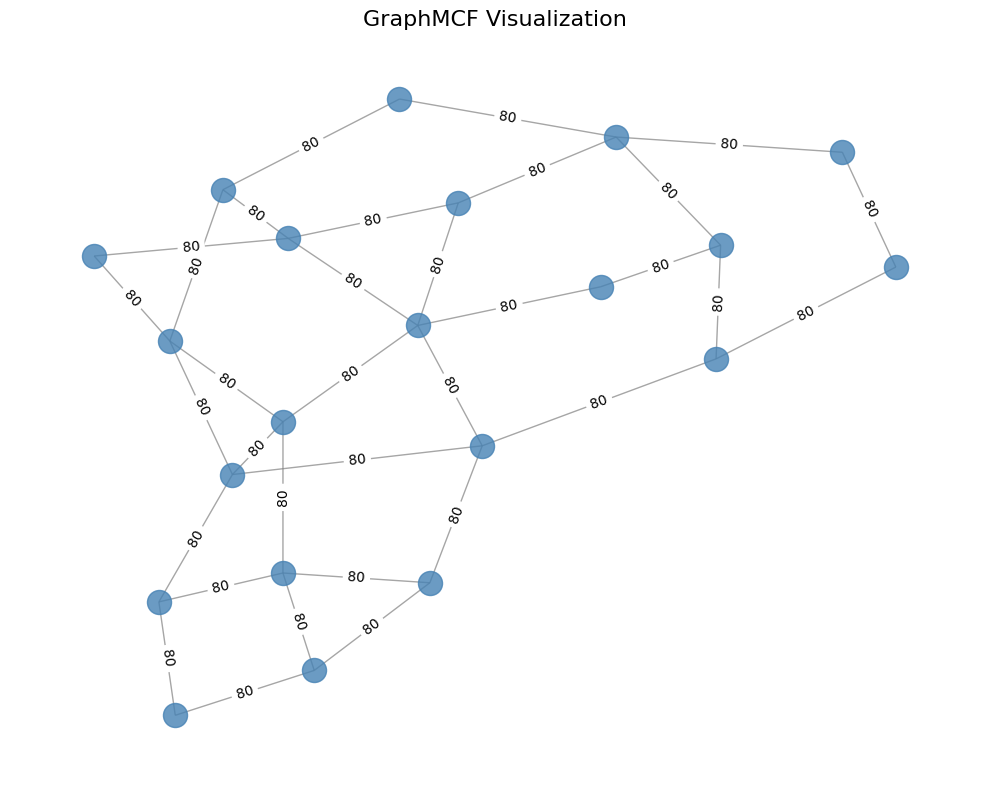

In [4]:
graphMCF = GraphMCF(main_graph_for_test['adj_matrix'])
graphMCF.visualize()

Генерация изначальной матрицы корреспонденций для алгоритма - выполняется случайно через модель Эрдеша-Решьи

/tmp/ipython-input-1491198765.py:257: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(demand_edge_cmap)


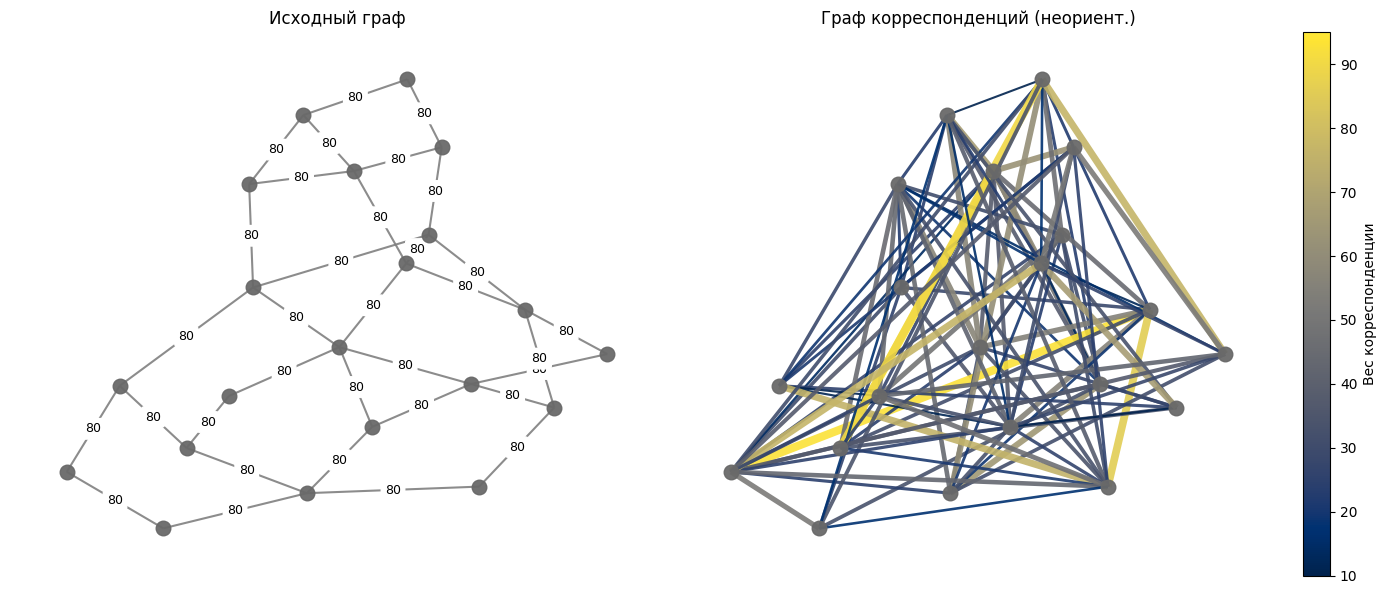

In [5]:
graphMCF.generate_initial_demands()
graphMCF.visualise_with_demands(
    node_size=110,
    demand_edge_width_range=(1.5, 6.0),
    seed=123,
    demand_edge_cmap='cividis'
)

Вычисление основного параметра алгоритма - параметр позволяет определять, в какую сторону менять проходимость корреспонденций

In [6]:
graphMCF.calculate_alpha()
print(graphMCF.alpha)

0.284334762867487


/tmp/ipython-input-1491198765.py:332: ComplexWarning: Casting complex values to real discards the imaginary part
  trace_val = float(np.trace(L_alpha))


Вычисление разреза интересующего типа

In [7]:
print(graphMCF.generate_cut(type='adversarial'))

[-0.27080458 -0.09407914  0.09808129  0.14359518 -0.10167722  0.33672955
  0.13026419 -0.23662828 -0.13867912  0.08989627 -0.18990191  0.22316229
 -0.35655762  0.10754195 -0.29463528 -0.1756886   0.21335756  0.45143655
  0.09452743 -0.19193813  0.16199761]


Работа основного алгоритма

/tmp/ipython-input-1491198765.py:332: ComplexWarning: Casting complex values to real discards the imaginary part
  trace_val = float(np.trace(L_alpha))
/tmp/ipython-input-1491198765.py:257: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap(demand_edge_cmap)


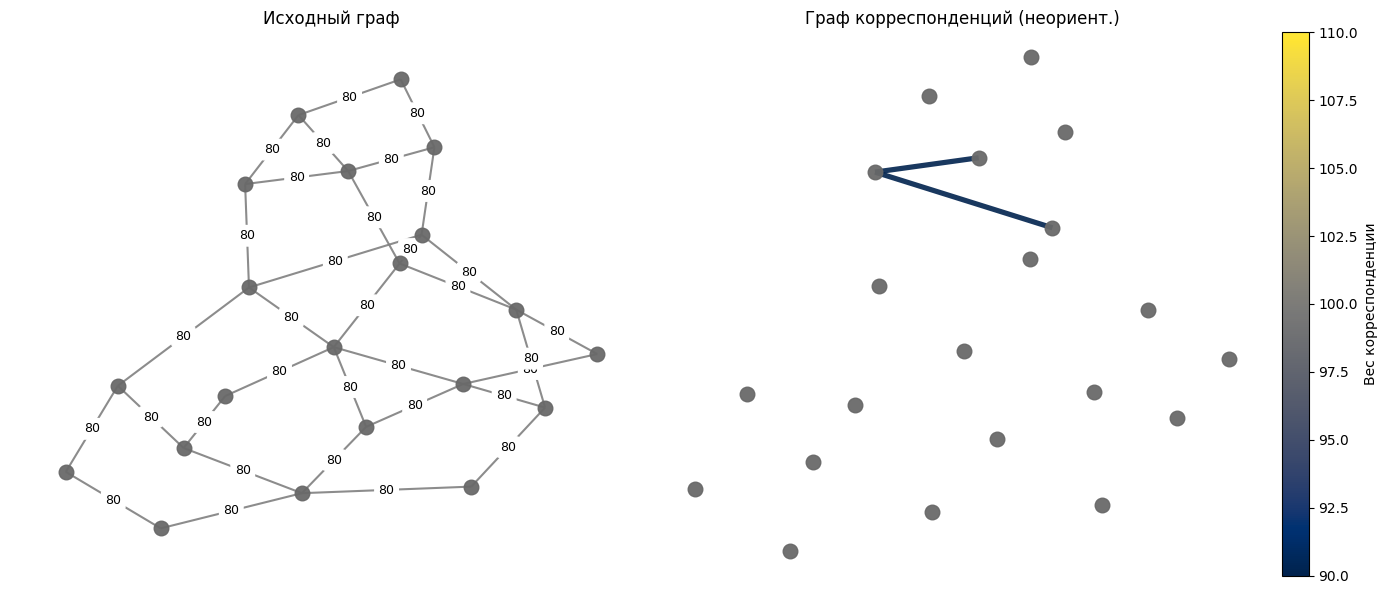

In [8]:
graphMCF.generate_demands(alpha_target=0.8, epsilon=0.05)
graphMCF.visualise_with_demands(
            node_size=110,
            demand_edge_width_range=(1.5, 6.0),
            seed=123,
            demand_edge_cmap='cividis'
        )

In [9]:
graphMCF.alpha_history

[0.2654476854731449,
 0.25887246538468706,
 0.2581317080815593,
 0.2588463393853811,
 0.26909328743937744,
 0.2693131833624592,
 0.2808683780245343,
 0.28187066084851964,
 0.27913470508637267,
 0.2752741295802803,
 0.2729921348570174,
 0.26951088691002273,
 0.26801531989193933,
 0.266402878314695,
 0.2666764812944739,
 0.26779159609565784,
 0.27344038603456183,
 0.2724332427458883,
 0.2715358272097702,
 0.2743912290718979,
 0.2756128860605554,
 0.2738290967298853,
 0.2741317593063587,
 0.27144864802194835,
 0.2697244465130278,
 0.269622096317126,
 0.2642473304076752,
 0.2632904526099293,
 0.25962867330833106,
 0.25905274302562287,
 0.2606757391423579,
 0.26558650719633364,
 0.2626933621764642,
 0.2557441380132734,
 0.25483458301338774,
 0.2552133805246294,
 0.2578577450024446,
 0.25491316117675933,
 0.2486383623234282,
 0.25607752972121123,
 0.2549166987740347,
 0.25427162565591277,
 0.2611263761687221,
 0.2596432698532678,
 0.26246989820319616,
 0.2640227947503782,
 0.2651469718165588